Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import gc
import datetime as datetime
import warnings
warnings.filterwarnings("ignore")

Import Data

In [2]:
df = pd.read_csv('nct_dream_data.csv',encoding = 'unicode_escape')
df.head()

,title,publishedAt,viewCount,likeCount,commentCount,duration,memberCount,category,keywords,subscriberCount
0,"DREAM SKETCH : Page #1 - Concert Meeting, Post...",2022-11-25T13:00:40Z,411160,56214,1624,1682,NaN,NaN,NaN,5.34
1,NCT DREAM THE MOVIE : In A DREAM | ScreenX Tra...,2022-11-24T23:00:09Z,112087,23301,350,31,NaN,NaN,NaN,5.34
2,????NCTzens ??????????????????? #NAGOYA#NCTDRE...,2022-11-24T04:27:05Z,91345,24341,140,37,NaN,NaN,NaN,5.34
3,???????????? ??? ?????????????? ??? ??? ?????...,2022-11-23T13:00:17Z,772833,101486,2409,1157,NaN,NaN,NaN,5.34
4,NCT DREAM THE MOVIE : In A DREAM | ScreenX Tra...,2022-11-17T23:00:21Z,168691,31192,474,31,NaN,NaN,NaN,5.32


# Data Wrangling

**Change the string of 'publishedAt' to DateTime** <br>

In [3]:
#Change publishedAt format to datetime (only date)
def to_date(iso_datetime):
    date = iso_datetime.split('T')[0]
    return date

df['publishedAt'] = pd.to_datetime(df['publishedAt'].apply(to_date))
df.head()

,title,publishedAt,viewCount,likeCount,commentCount,duration,memberCount,category,keywords,subscriberCount
0,"DREAM SKETCH : Page #1 - Concert Meeting, Post...",2022-11-25,411160,56214,1624,1682,NaN,NaN,NaN,5.34
1,NCT DREAM THE MOVIE : In A DREAM | ScreenX Tra...,2022-11-24,112087,23301,350,31,NaN,NaN,NaN,5.34
2,????NCTzens ??????????????????? #NAGOYA#NCTDRE...,2022-11-24,91345,24341,140,37,NaN,NaN,NaN,5.34
3,???????????? ??? ?????????????? ??? ??? ?????...,2022-11-23,772833,101486,2409,1157,NaN,NaN,NaN,5.34
4,NCT DREAM THE MOVIE : In A DREAM | ScreenX Tra...,2022-11-17,168691,31192,474,31,NaN,NaN,NaN,5.32


**Add the duration of days past since the data is collected**

In [4]:
# date_collected = '2022-11-26'.
df['daysPassed'] = (pd.to_datetime('2022-11-26')-df['publishedAt']).dt.days.astype('int')
df.head()

,title,publishedAt,viewCount,likeCount,commentCount,duration,memberCount,category,keywords,subscriberCount,daysPassed
0,"DREAM SKETCH : Page #1 - Concert Meeting, Post...",2022-11-25,411160,56214,1624,1682,NaN,NaN,NaN,5.34,1
1,NCT DREAM THE MOVIE : In A DREAM | ScreenX Tra...,2022-11-24,112087,23301,350,31,NaN,NaN,NaN,5.34,2
2,????NCTzens ??????????????????? #NAGOYA#NCTDRE...,2022-11-24,91345,24341,140,37,NaN,NaN,NaN,5.34,2
3,???????????? ??? ?????????????? ??? ??? ?????...,2022-11-23,772833,101486,2409,1157,NaN,NaN,NaN,5.34,3
4,NCT DREAM THE MOVIE : In A DREAM | ScreenX Tra...,2022-11-17,168691,31192,474,31,NaN,NaN,NaN,5.32,9


**Fill in empty data for Subscribers using fitting** <br>
Youtube API does not provide the number of subscribers by date. I have achieved 82 (or 6 months worth) of subscriber count data from third party. This data will be used for analysis and prediction of the previous empty data.

Text(0, 0.5, 'subscribers')

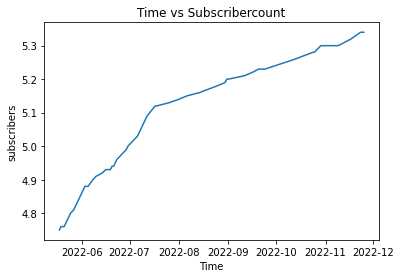

In [5]:
# Visualize non NAN columns for subscriberCount
df_sub= df[['publishedAt','subscriberCount']]
df_sub = df_sub.dropna()

plt.plot(df_sub['publishedAt'],df_sub['subscriberCount'])
plt.title('Time vs Subscribercount')
plt.xlabel("Time")
plt.ylabel("subscribers")


From the plot, we can interpret that the number of subscribers are increasing. The increasing trend seems somewhat linear but also seems to concave downwards. <br>
We will fit this data to a logarithmic fit 

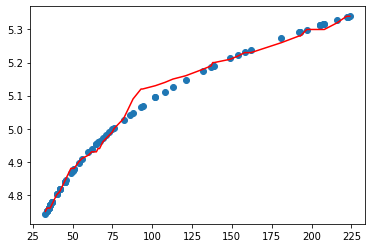

In [6]:
df_sub['toOrdinal']=df_sub['publishedAt'].apply(lambda x: x.toordinal())
x = np.array(df_sub['toOrdinal'])
y = np.array(df_sub['subscriberCount'])

#fit the log value of x(date created). Find an arbitrary number to deduct from x to fit the plot
x = x-738260
x_log = np.log(x)
a,b = np.polyfit(x_log,y,1)
plt.plot(x,a*x_log+b,'o')
plt.plot(x,y,'r')

This logarithmic regression does very well with the limited data we have. <br>
However, the ordinal date the channel has been created is smaller than the number we deduct from x. Thus, this result in logarithm of a negative number, which is not a real number.<br>
So, in this case, we will add data which has the ordinal date equal to when the channel has been made and set the subscriber to 0.<br>
The subscriber data that I have achieved from third party data is in millions. Therefore, even if there were minimal subscribers on the very day the channel was made, it is small enough to ignore.<br>
Now, with the added data, we will see if we can fit an ordinary least squares 

In [7]:
import statsmodels.api as sm

#Add the date of the creation of account and subscriber to 0 at the time
x = np.array(df_sub['toOrdinal'])
y = np.array(df_sub['subscriberCount'])
y = np.append(y,0)
date_created = datetime.datetime.strptime('7/6/17',"%d/%m/%y").toordinal()
x = np.append(x,date_created)

# Run an ordinary least squares for linear regression
x_const= sm.add_constant(x) #for constant parameter

ols_fit = sm.OLS(y,x_const).fit()
print(ols_fit.params)
print(ols_fit.summary())

ypred = ols_fit.predict(x_const)`
plt.plot(x[:82],y[:82],'o')
plt.plot(x[:82],ypred[:82])

SyntaxError: invalid syntax (Temp/ipykernel_3388/3007767326.py, line 17)

From the OLS summary, both R-squared and adjusted R-squared are large(0.990,0.989>0.975) andd the p value is very small (<0.05). We can say that the model does not have enough evidence to be insignificant. Therefore, we will use this model for the NaN data for subscriber count.

10

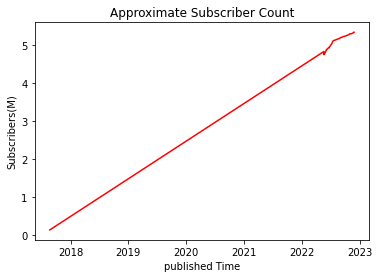

In [8]:
def subscriberPred(x): #from ols params above
    return -2000.58514 + 0.00271629042 *x

df_sub2=df[['publishedAt']].copy()
df_sub2['toOrdinal'] = df_sub2['publishedAt'].apply(lambda x: x.toordinal())
df_sub2 = df_sub2.drop(['publishedAt'],axis=1)
df_sub2['subscriberCountPred'] = df_sub2['toOrdinal'].apply(subscriberPred)

df['subscriberCountPred'] = df_sub2['subscriberCountPred']
df['subscriberCountPred'][:82] = df['subscriberCount'][:82]

plt.plot(df['publishedAt'],df['subscriberCountPred'],color="red")
plt.title("Approximate Subscriber Count")
plt.xlabel("published Time")
plt.ylabel("Subscribers(M)")

# Delete sub dataframes
del df_sub
del df_sub2

gc.collect()


**Label Category** <br>
From the 'keywords' column, create columns with significant keywords.<br>
Label each video as 1 if 'keywords' include the keyword and 0 if not.
(Keywords are manually added)